# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [37]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v3 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [38]:
# Download the dataset
# !wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# # Unzip the '.tar.gz' file to the current directory
# datafile = tarfile.open('Task01_BrainTumour_2D.tar')
# datafile.extractall()
# datafile.close()

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

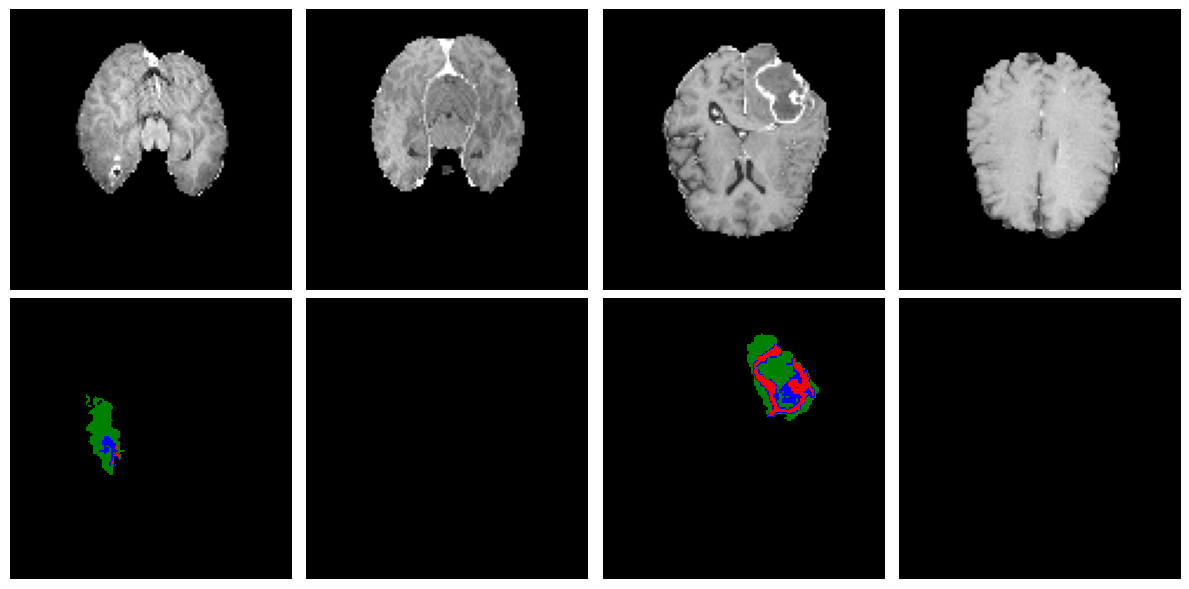

In [39]:

### Insert your code ###

# Set the paths to the training images and label maps
image_path = 'Task01_BrainTumour_2D/training_images'
label_path = 'Task01_BrainTumour_2D/training_labels'

# Get a list of image and label map filenames
image_filenames = sorted(os.listdir(image_path))
label_filenames = sorted(os.listdir(label_path))

# Select 4 random indices
random_indices = random.sample(range(len(image_filenames)), 4)

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Set the suggested color maps
image_cmap = 'gray'
segmentation_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Iterate over the random indices
for i, idx in enumerate(random_indices):
    # Read the image and label map
    image = imageio.imread(os.path.join(image_path, image_filenames[idx]))
    label = imageio.imread(os.path.join(label_path, label_filenames[idx]))

    # Plot the image and label map in the corresponding subplot
    axs[0, i].imshow(image, cmap=image_cmap)
    axs[0, i].axis('off')

    axs[1, i].imshow(label, cmap=segmentation_cmap)
    axs[1, i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [40]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###

        # Randomly select a set of indices
        indices = np.random.choice(len(self.images), batch_size)

        # Iterate over the indices
        for idx in indices:
            # Get the image and label map
            image, label = self.__getitem__(idx)

            # Add the image and label map to the list
            images.append(image)
            labels.append(label)

        # Convert the list of images and label maps to numpy arrays
        #add 1 dimension to the images of size 1 at 2nd dimension
        images = np.array(images)
        images = np.expand_dims(images, axis=1)
        labels = np.array(labels)       

        ### End of your code ###
        return images, labels
    
# Test the function
# Create a dataset
image_path = 'Task01_BrainTumour_2D/training_images'
label_path = 'Task01_BrainTumour_2D/training_labels'
dataset = BrainImageSet(image_path, label_path)
# Get a random batch
images, labels = dataset.get_random_batch(20)


    

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [46]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###

        n //= 2  # 64
        self.transpose1 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv1 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 32
        self.transpose2 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 16
        self.transpose3 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )


        # Final convolutional layer
        self.conv_final = nn.Conv2d(n, output_channel, kernel_size=1)

        
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        

        x = self.transpose1(x)
        x = torch.cat((conv3_skip, x), dim=1)
        x = self.deconv1(x)

        x = self.transpose2(x)
        x = torch.cat((conv2_skip, x), dim=1)
        x = self.deconv2(x)

        x = self.transpose3(x)
        x = torch.cat((conv1_skip, x), dim=1)
        x = self.deconv3(x)

        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [47]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 1000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    # Print out the training loss
    print('Iteration: {0}, Training Loss: {1:.4f}'.format(it, loss.item()))
    

    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)

            # Calculate the loss
            loss = criterion(logits, labels)
            print('Iteration: {0}, Test Loss: {1:.4f}'.format(it, loss.item()))

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cpu
Iteration: 1, Training Loss: 2.9881
Iteration: 2, Training Loss: 2.8678
Iteration: 3, Training Loss: 2.8103
Iteration: 4, Training Loss: 2.7785
Iteration: 5, Training Loss: 2.7491
Iteration: 6, Training Loss: 2.7297
Iteration: 7, Training Loss: 2.7080
Iteration: 8, Training Loss: 2.6926
Iteration: 9, Training Loss: 2.6781
Iteration: 10, Training Loss: 2.6574
Iteration: 11, Training Loss: 2.6411
Iteration: 12, Training Loss: 2.6334
Iteration: 13, Training Loss: 2.6199
Iteration: 14, Training Loss: 2.5998
Iteration: 15, Training Loss: 2.5937
Iteration: 16, Training Loss: 2.6055
Iteration: 17, Training Loss: 2.5828
Iteration: 18, Training Loss: 2.5666
Iteration: 19, Training Loss: 2.5596
Iteration: 20, Training Loss: 2.5399
Iteration: 21, Training Loss: 2.5393


## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

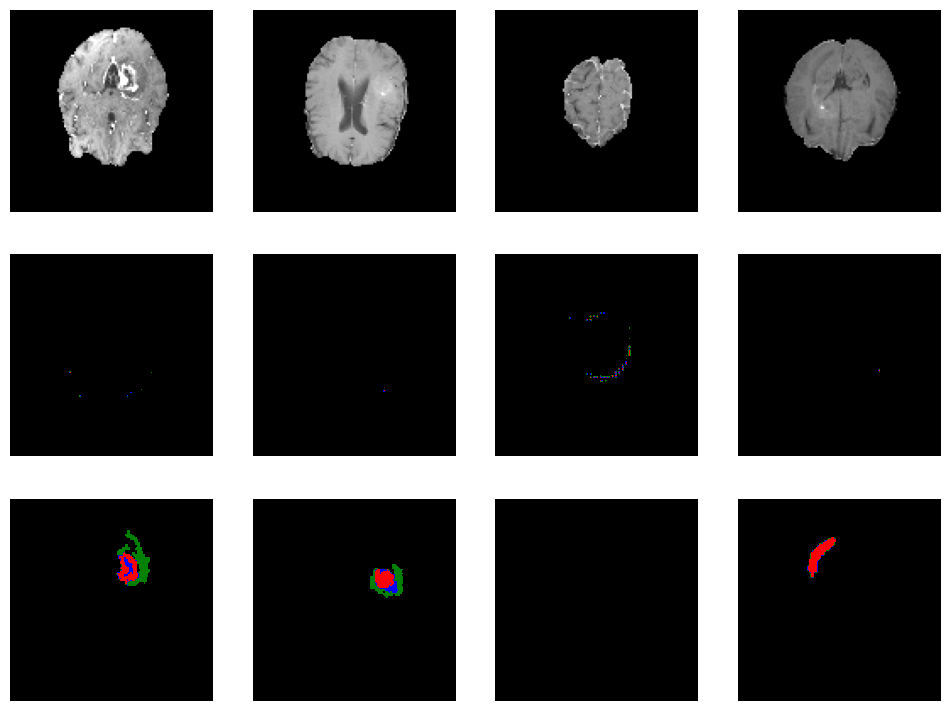

In [ ]:
### Insert your code ###

### 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.
#You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

# Select 4 random indices
random_indices = random.sample(range(len(test_set)), 4)

# Create a figure with 4 subplots
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

# Set the suggested color maps
image_cmap = 'gray'
segmentation_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

test_size = 4

# Iterate over the random indices
for i, idx in enumerate(random_indices):

    # images, labels = train_set.get_random_batch(train_batch_size)
    # images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    # images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    # logits = model(images)

    # Read the image and label map
    image, label = test_set.get_random_batch(1)
    

    # Convert the image to a tensor and add a batch dimension
    image = torch.from_numpy(image).to(device, dtype=torch.float32)

    # Evaluate Model
    logits = model(image)
    pred = logits.argmax(dim=1)

    # Plot the image, automated segmentation and ground truth segmentation in the corresponding subplot
    axs[0, i].imshow(image.squeeze().cpu().numpy(), cmap=image_cmap)
    axs[0, i].axis('off')

    axs[1, i].imshow(pred.squeeze().cpu().numpy(), cmap=segmentation_cmap)
    axs[1, i].axis('off')

    axs[2, i].imshow(label.squeeze(), cmap=segmentation_cmap)
    axs[2, i].axis('off')

### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?